In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import pickle

from cnp.cnp import StandardPredPreyConvGNP, FullConvGNP
from cnp.cov import (
    MeanFieldGaussianLayer,
    InnerprodGaussianLayer,
    KvvGaussianLayer,
    ExponentialCopulaLayer
)
from cnp.lnp import StandardPredPreyConvNP

import stheno
from shutil import copyfile

from collections import OrderedDict

from itertools import product

import matplotlib

from cnp.experiment import WorkingDirectory
# matplotlib.rcParams['text.usetex'] = True

# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')

def to_numpy(tensor):
    return tensor.cpu().detach().numpy()

In [2]:
args_num_basis_dim = 32
args_jitter = 1e-4

In [3]:
def load_model(model_name, device, working_directory):
    
    if 'convgnp' in model_name and not('fullconvgnp' in model_name):
        
        output_layer = None

        if 'meanfield' in model_name:
            output_layer = MeanFieldGaussianLayer()

        elif 'innerprod' in model_name:
            output_layer = InnerprodGaussianLayer(num_embedding=args_num_basis_dim,
                                                  noise_type='hetero',
                                                  jitter=args_jitter)

        elif 'kvv' in model_name:
            output_layer = KvvGaussianLayer(num_embedding=args_num_basis_dim,
                                            noise_type='hetero',
                                            jitter=args_jitter)

        if 'exponential' in model_name:
            output_layer = ExponentialCopulaLayer(gaussian_layer=output_layer,
                                                  device=device)

        model = StandardPredPreyConvGNP(input_dim=1,
                                        output_layer=output_layer)
        
    elif 'convnp' in model_name:
        model = StandardPredPreyConvNP(input_dim=1, num_samples=16)

    elif 'fullconvgnp' in model_name:
        model = FullConvGNP(points_per_unit_mean=16,
                            points_per_unit_kernel=8)

    # Load model to appropriate device
    model = model.to(device)

    # Load model from saved state
    load_dict = torch.load(working_directory.file(f'{model_name}', exists=True))
    model.load_state_dict(load_dict['state_dict'])
    
    return model

In [4]:
# root = '../../experiments/predator-prey/results'
# data = 'sim-pred-prey-100-16-50-100-100-0'

# copyfile(f'{root}/{data}/models/convGNP/meanfield/hetero/identity/seed-0/model_best.pth.tar', 'models/convgnp-meanfield-identity')
# copyfile(f'{root}/{data}/models/convGNP/innerprod/hetero/identity/seed-0/model_best.pth.tar', 'models/convgnp-innerprod-identity')
# copyfile(f'{root}/{data}/models/convGNP/kvv/hetero/identity/seed-0/model_best.pth.tar', 'models/convgnp-kvv-identity')

# copyfile(f'{root}/{data}/models/convGNP/meanfield/hetero/exponential/seed-0/model_best.pth.tar', 'models/convgnp-meanfield-exponential')
# copyfile(f'{root}/{data}/models/convGNP/innerprod/hetero/exponential/seed-0/model_best.pth.tar', 'models/convgnp-innerprod-exponential')
# copyfile(f'{root}/{data}/models/convGNP/kvv/hetero/exponential/seed-0/model_best.pth.tar', 'models/convgnp-kvv-exponential')

# copyfile(f'{root}/{data}/models/convNP/meanfield/homo/identity/seed-0/model_best.pth.tar', 'models/convnp-identity')
# copyfile(f'{root}/{data}/models/FullConvGNP/meanfield/homo/identity/seed-0/model_best.pth.tar', 'models/fullconvgnp-identity')

model_directory = WorkingDirectory('/scratches/cblgpu07/em626/kernelcnp/kernelcnp/notebooks/pred-prey-results/models')
device = torch.device('cuda')

Root: /scratches/cblgpu07/em626/kernelcnp/kernelcnp/notebooks/pred-prey-results/models


# Load data

In [92]:
file = open('../../experiments/predator-prey/simulated-data/sim-pred-prey-100-16-50-100-100-0/valid-data.pkl', 'rb')
batch = pickle.load(file)[0][1]
file.close()

x_context = batch['x_context'][:1, :, None].to(device)
y_context = batch['y_context'][:1, 0, :, None].to(device) / 100 + 1e-2
x_target = batch['x_target'][:1, :, None].to(device)
y_target = batch['y_target'][:1, 0, :, None].to(device) / 100 + 1e-2


x_context = x_context[:, ::5, :][:, :x_context.shape[1]//2, :]
y_context = y_context[:, ::5, :][:, :y_context.shape[1]//2, :]
x_target = x_target[:, :, :]
y_target = y_target[:, :, :]


x_context = torch.cat([x_context[:, :4, :], x_context[:, 5:, :]], axis=1)
y_context = torch.cat([y_context[:, :4, :], y_context[:, 5:, :]], axis=1)

# Posterior plots

In [93]:
models = [
    ('ConvGNP (meanfield)', StandardPredPreyConvGNP, 'convgnp-meanfield-identity'),
    ('ConvGNP (linear)', StandardPredPreyConvGNP, 'convgnp-innerprod-identity'),
    ('ConvGNP (kvv)', StandardPredPreyConvGNP, 'convgnp-kvv-identity'),
    ('ConvNP', StandardPredPreyConvNP, 'convnp-identity'),
    ('ConvGNP (meanfield)', StandardPredPreyConvGNP, 'convgnp-meanfield-exponential'),
    ('ConvGNP (linear)', StandardPredPreyConvGNP, 'convgnp-innerprod-exponential'),
    ('ConvGNP (kvv)', StandardPredPreyConvGNP, 'convgnp-kvv-exponential'),
    ('FullConvGNP', FullConvGNP, 'fullconvgnp-identity'),
]

tensor(37.3331, device='cuda:0', grad_fn=<NegBackward>)
tensor(-30.5327, device='cuda:0', grad_fn=<NegBackward>)
tensor(-88.6983, device='cuda:0', grad_fn=<NegBackward>)
tensor(-33.4225, device='cuda:0', grad_fn=<DivBackward0>)
tensor(8.6958, device='cuda:0', grad_fn=<NegBackward>)
tensor(-25.5728, device='cuda:0', grad_fn=<NegBackward>)
tensor(-82.1202, device='cuda:0', grad_fn=<NegBackward>)
tensor(156.7733, device='cuda:0', grad_fn=<CopyBackwards>)


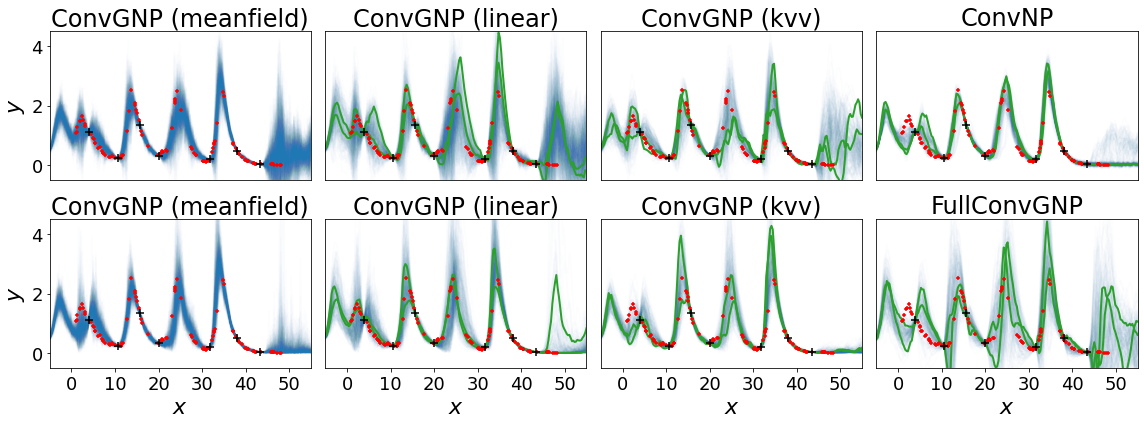

In [96]:
num_noisy_samples = 256
num_noiseless_samples = 2

x_plot = torch.linspace(-5., 55., 200)[None, :, None].to(device)

fig = plt.figure(figsize=(16, 6))

for i, (model_title, model_class, model_name) in enumerate(models):
    
    plt.subplot(2, 4, i+1)
    
    # Load model
    model = load_model(model_name, device=device, working_directory=model_directory)
    
    # Draw samples (noisy and noiseless)
    samples = model.sample(x_context,
                           y_context,
                           x_plot,
                           num_samples=num_noisy_samples,
                           noiseless=False,
                           double=True)
    
    # Plot data and samples
    plt.plot(to_numpy(x_plot[0, :, 0]),
             to_numpy(samples[:, 0, :]).T,
             color='tab:blue',
             alpha=0.01,
             zorder=1)
    
    # Draw samples (noisy and noiseless)
    if model_name == 'convgnp-meanfield-identity' or \
       model_name == 'convgnp-meanfield-exponential':
        samples = model.sample(x_context,
                               y_context,
                               x_plot,
                               num_samples=200,
                               noiseless=True,
                               double=True)
        samples = torch.mean(samples, axis=0)[None, :, :]
        
    else:
        samples = model.sample(x_context,
                               y_context,
                               x_plot,
                               num_samples=num_noiseless_samples,
                               noiseless=True,
                               double=True)
    
    # Plot data and samples
    
    if not (model_name == 'convgnp-meanfield-identity' or \
            model_name == 'convgnp-meanfield-exponential'):
        plt.plot(to_numpy(x_plot[0, :, 0]),
                 to_numpy(samples[:, 0, :]).T,
                 color='tab:green',
                 alpha=1.0,
                 zorder=2,
                 linewidth=2)
    
    plt.scatter(to_numpy(x_context)[0, :, 0],
                to_numpy(y_context)[0, :, 0],
                color='black',
                marker='+',
                s=50,
                zorder=4)
    
    plt.scatter(to_numpy(x_target)[0, :, 0],
                to_numpy(y_target)[0, :, 0],
                color='red',
                marker='+',
                s=20,
                zorder=3)
    
    plt.xlim([-5, 55])
    plt.ylim([-0.5, 4.5])
    
    if i < 4:
        plt.xticks([])
    else:
        plt.xticks(np.linspace(0, 50, 6), fontsize=18)
        plt.xlabel('$x$', fontsize=22)
    
    if i % 4 != 0:
        plt.yticks([])
    else:
        plt.yticks(np.linspace(0, 4, 3), fontsize=18)
        plt.ylabel('$y$', fontsize=22)
        
    plt.title(model_title, fontsize=24)
    
    print(model.loss(x_context, y_context, x_target, y_target))
    
plt.tight_layout()
plt.show()